<a href="https://colab.research.google.com/github/JinHuiXu1991/Jin_DATA606/blob/main/ipynb/DATA606_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Product Recommender Systems
## Author: Jin Hui Xu



# Exploratory Data Analysis

The data for this project is the Amazon Review Data (2018) which is collected by the University of California San Diego (https://nijianmo.github.io/amazon/index.html). 

The dataset includes reviews (rating, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features). It contains a total number of 233.1 million real reviews with the size of 34 gigabytes from Amazon. I would use a subset of this data due to the computing resource limitation. The smaller dataset is the subset of the data in a specific domain/category.

For this project, the Appliance category is chosen because it has a moderate number of review and product records. This notebook loads the customer reviews dataset and product metadata needed for the study.

## Load Data and import necessary libraries

The required datasets are pre-downloaded into the project GitHub repository. The following code blocks are used to download the files from Github and define the necessary libraries and helper functions to perform exploratory data analysis.

In [1]:
!wget https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/source_data/Appliances.json.gz?raw=true

!wget https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/source_data/meta_Appliances.json.gz?raw=true

--2022-02-27 02:20:58--  https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/source_data/Appliances.json.gz?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/JinHuiXu1991/Jin_DATA606/raw/main/source_data/Appliances.json.gz [following]
--2022-02-27 02:20:58--  https://github.com/JinHuiXu1991/Jin_DATA606/raw/main/source_data/Appliances.json.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JinHuiXu1991/Jin_DATA606/main/source_data/Appliances.json.gz [following]
--2022-02-27 02:20:58--  https://raw.githubusercontent.com/JinHuiXu1991/Jin_DATA606/main/source_data/Appliances.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com 

In [2]:
!pip3 install simplejson

     |████████████████████████████████| 130 kB 21.3 MB/s 


In [3]:
import pandas as pd
import gzip
import simplejson as json
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
import seaborn as sns
from IPython.display import Image
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS

In [4]:
# helper functions to load the zip file and read it into the pandas dataframe
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

## Review data

The following code blocks will clean the review dataset and perform exploratory analysis against the cleaned dataset.

### Data Cleaning

Load the original review dataset and clean it before use

In [5]:
review_df = getDF('/content/Appliances.json.gz?raw=true')

In [6]:
review_df.head(10)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5.0,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5.0,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5.0,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5.0,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN
5,5.0,NaN,False,"05 11, 2014",A17K8WANMYHTX2,1118461304,{'Format:': ' Hardcover'},mark h wellman,I teach a class on innovation and I used the N...,Insightful & Very Useful!,1399766400,NaN
6,5.0,NaN,False,"05 9, 2014",A13IW3A6W43U0G,1118461304,{'Format:': ' Hardcover'},Mmf,I so appreciated the insights and perspective ...,The necessity of this book!,1399593600,NaN
7,5.0,NaN,True,"05 7, 2014",A1ECEGG1MP7J8J,1118461304,{'Format:': ' Hardcover'},G. Deatherage,"As with ""Surrounded by Genius"", Alan Gregerman...",Great insight-Great book,1399420800,NaN
8,5.0,NaN,False,"05 4, 2014",A2D5X9G9S3A7RN,1118461304,{'Format:': ' Hardcover'},Teresa Fritsch,Alan Gregermans book provides valuable ideas f...,The Necessity of Strangers dares you to be ope...,1399161600,NaN
9,5.0,NaN,False,"05 2, 2014",AP2F86JFRQ205,1118461304,{'Format:': ' Hardcover'},Ken Harris,I am a believer in Alan Gregerman. I have enj...,Review: The Necessity of Strangers,1398988800,NaN


In [7]:
review_df.shape

(602777, 12)

We choose the Appliance category from the entire Amazon review dataset because it has a moderate number of review and product records. There are a total of 602,777 review records in this category, and the dataset has 12 different features.

<h3>The most important feature of the review dataset is the overall rating, so we check if any record has a null rating value.</h3>

In [8]:
review_df.isnull().sum()

overall                0
vote              537515
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             464804
reviewerName          15
reviewText           324
summary              128
unixReviewTime         0
image             593519
dtype: int64

In [9]:
review_df = review_df.fillna('')
review_df.isnull().sum()

overall           0
vote              0
verified          0
reviewTime        0
reviewerID        0
asin              0
style             0
reviewerName      0
reviewText        0
summary           0
unixReviewTime    0
image             0
dtype: int64

All review records have rating value, but a few of them are having no review text and summary which is acceptable for meeting the real-world situation. However, we will need to fill these null values with empty string.

<h3>Check dataset column data types</h3>

In [10]:
review_df.dtypes

overall           float64
vote               object
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
image              object
dtype: object

<h3>Convert review time to datetime data type and extract review year and month</h3> 

The review time could be an important factor to understand customers' purchasing preferences, so year and month should be extracted from the review time.

In [11]:
review_df['reviewTime'] = pd.to_datetime(review_df['reviewTime'].str.strip())
review_df['reviewTimeYear'] = review_df['reviewTime'].dt.year
review_df['reviewTimeMonth'] = review_df['reviewTime'].dt.month

<h3>Drop the unnecessary columns from the original dataset.</h3>

In [12]:
review_df = review_df[['overall', 'reviewTime', 'reviewerID', 'asin', 'reviewText', 'summary', 'reviewTimeYear', 'reviewTimeMonth']]

In [13]:
review_df.head(10)

,overall,reviewTime,reviewerID,asin,reviewText,summary,reviewTimeYear,reviewTimeMonth
0,5.0,2013-11-27,A3NHUQ33CFH3VM,1118461304,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,2013,11
1,5.0,2013-11-01,A3SK6VNBQDNBJE,1118461304,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,2013,11
2,5.0,2013-10-10,A3SOFHUR27FO3K,1118461304,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,2013,10
3,5.0,2013-10-09,A1HOG1PYCAE157,1118461304,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,2013,10
4,5.0,2013-09-07,A26JGAM6GZMM4V,1118461304,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",2013,9
5,5.0,2014-05-11,A17K8WANMYHTX2,1118461304,I teach a class on innovation and I used the N...,Insightful & Very Useful!,2014,5
6,5.0,2014-05-09,A13IW3A6W43U0G,1118461304,I so appreciated the insights and perspective ...,The necessity of this book!,2014,5
7,5.0,2014-05-07,A1ECEGG1MP7J8J,1118461304,"As with ""Surrounded by Genius"", Alan Gregerman...",Great insight-Great book,2014,5
8,5.0,2014-05-04,A2D5X9G9S3A7RN,1118461304,Alan Gregermans book provides valuable ideas f...,The Necessity of Strangers dares you to be ope...,2014,5
9,5.0,2014-05-02,AP2F86JFRQ205,1118461304,I am a believer in Alan Gregerman. I have enj...,Review: The Necessity of Strangers,2014,5


Now, all the null values are handled and only the useful columns are kept in the dataset, so the cleaned review dataset is ready to be used for exploratory data analysis.

### Data Analysis



<h3>Display the overall rating in the dataset and its distribution</h3>

In [14]:
review_df['overall'].value_counts()

5.0    416288
4.0     75476
1.0     59627
3.0     30652
2.0     20734
Name: overall, dtype: int64

In [15]:
review_df['overall'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

5.0    69.1%
4.0    12.5%
1.0     9.9%
3.0     5.1%
2.0     3.4%
Name: overall, dtype: object

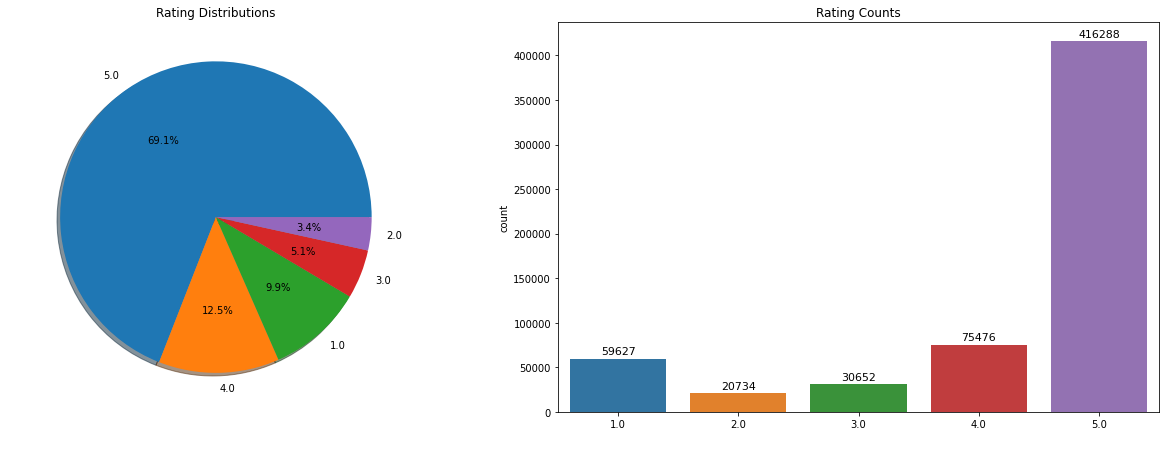

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
plt.tight_layout()

review_df['overall'].value_counts().plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)
ax=sns.countplot(x="overall", data=review_df, ax=axes[1])

for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Rating Distributions')
axes[0].set_ylabel(' ')

axes[1].set_title('Rating Counts')
axes[1].set_xlabel(' ')

plt.show()

In [17]:
print('rating mean: {}'.format(review_df['overall'].mean()))
print('rating median: {}'.format(review_df['overall'].median()))

rating mean: 4.2742092017445925
rating median: 5.0


The results show that the overall ratings in this review data set are highly imbalanced, which contains more than 69% of 5 stars rating. 

Thus, in the following model development, we need to keep in mind that the accuracy metric may not be useful for evaluating the machine learning models; instead, precision, recall,  and F1 score values could be suitable for model evaluation.

<h3>List the ranking of most active reviewers and their review average ratings.</h3>

In [18]:
reviewer_grouped = review_df.groupby('reviewerID').size().reset_index(name='counts')
reviewer_grouped_rating = review_df.groupby('reviewerID')['overall'].sum().reset_index(name='overall_sum')
reviewer_grouped['rating_mean'] = reviewer_grouped_rating['overall_sum'] / reviewer_grouped['counts']
reviewer_grouped.sort_values('counts', ascending=False)

,reviewerID,counts,rating_mean
412749,A8WEXFRWX1ZHH,208,4.980769
71295,A1IT56MV1C09VS,207,4.995169
142776,A21TPY9BVC9IKZ,206,5.000000
156061,A25C30G90PKSQA,206,3.000000
384058,A3TMNU7VNK5JJE,206,3.000000
...,...,...,...
183327,A2CH9B6K2QJS6Z,1,5.000000
183326,A2CH8ZFJWN1R60,1,5.000000
183325,A2CH7FPVP7H0XX,1,5.000000
183323,A2CH75VNS4T0GV,1,4.000000


There are a total of 515,650 distinct reviewers in this dataset, and the most active reviewer had reviewed 208 products with an average 4.98 rating score.

<h3>Display the review time and its distribution in the dataset</h3>

In [19]:
review_df['reviewTimeYear'].value_counts()

2016    140696
2017    135978
2015    110286
2018     77422
2014     71126
2013     38477
2012     13820
2011      7406
2010      3677
2009      1781
2008      1080
2007       640
2006       262
2005        96
2004        25
2003         2
2001         1
2002         1
2000         1
Name: reviewTimeYear, dtype: int64

In [20]:
review_df['reviewTimeYear'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

2016    23.3%
2017    22.6%
2015    18.3%
2018    12.8%
2014    11.8%
2013     6.4%
2012     2.3%
2011     1.2%
2010     0.6%
2009     0.3%
2008     0.2%
2007     0.1%
2006     0.0%
2005     0.0%
2004     0.0%
2003     0.0%
2001     0.0%
2002     0.0%
2000     0.0%
Name: reviewTimeYear, dtype: object

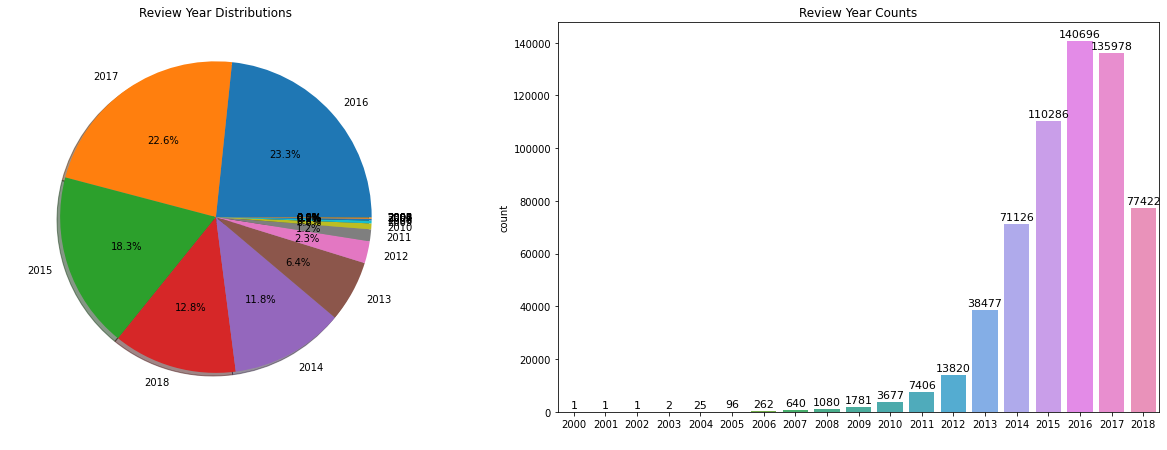

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
plt.tight_layout()

review_df['reviewTimeYear'].value_counts().plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)
ax=sns.countplot(x="reviewTimeYear", data=review_df, ax=axes[1])

for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Review Year Distributions')
axes[0].set_ylabel(' ')

axes[1].set_title('Review Year Counts')
axes[1].set_xlabel(' ')

plt.show()

The results show that the reviews in this dataset are heavily collected after the year 2012, which can quite well represent the current generation customers' preferences.

<h3>Let's display the review month and see if the season is an important factor to influence the purchase of the appliances.</h3>

In [22]:
review_df['reviewTimeMonth'].value_counts()

3     60462
1     57548
2     53935
8     52340
7     50664
12    49953
4     49485
5     47401
9     46662
6     46328
10    44469
11    43530
Name: reviewTimeMonth, dtype: int64

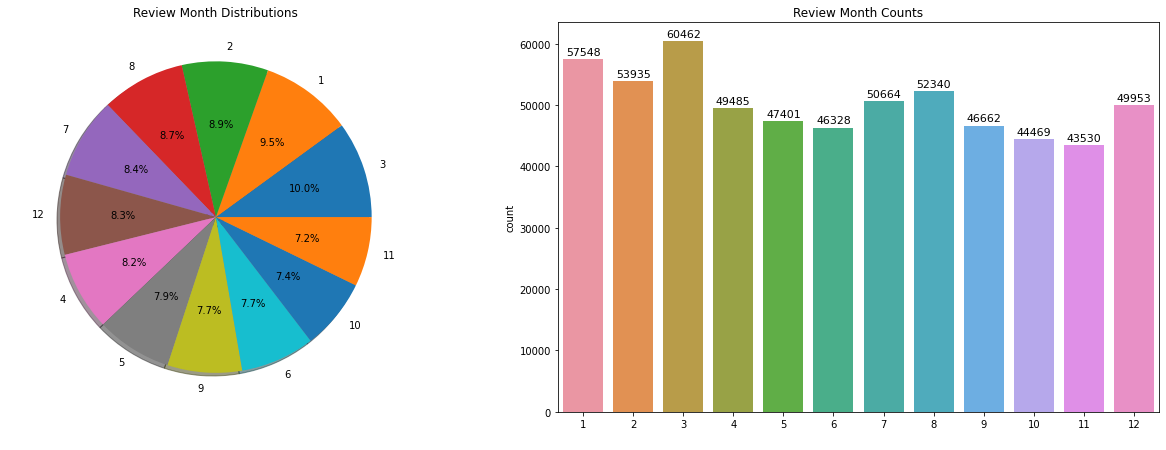

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
plt.tight_layout()

review_df['reviewTimeMonth'].value_counts().plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)
ax=sns.countplot(x="reviewTimeMonth", data=review_df, ax=axes[1])

for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Review Month Distributions')
axes[0].set_ylabel(' ')

axes[1].set_title('Review Month Counts')
axes[1].set_xlabel(' ')

plt.show()

The results show that the months are quite evenly distributed in the dataset, which we can conclude that the season doesn't play a significant role in the influence of the purchase of the appliances.

### Review text analysis



Remove stop word from the review text and apply text tokenization

In [24]:
nltk.download('stopwords')
nltk.download('wordnet')
stop = stopwords.words('english')

# Word tokenization helper functions

# tokenization 
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Append two textual data columns into a single column then tokenize the text data altogether. Besides, count the word numbers for each review record.

In [25]:
review_df['all_text'] = review_df['reviewText'] + ' ' + review_df['summary'] 
review_df['all_text_token'] = review_df['all_text'].apply(tokenizer)
review_df['word_count'] = review_df['all_text_token'].str.len()

In [26]:
review_df.head(5)

,overall,reviewTime,reviewerID,asin,reviewText,summary,reviewTimeYear,reviewTimeMonth,all_text,all_text_token,word_count
0,5.0,2013-11-27,A3NHUQ33CFH3VM,1118461304,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,2013,11,Not one thing in this book seemed an obvious o...,"[one, thing, book, seemed, obvious, original, ...",73
1,5.0,2013-11-01,A3SK6VNBQDNBJE,1118461304,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,2013,11,I have enjoyed Dr. Alan Gregerman's weekly blo...,"[enjoyed, dr, alan, gregerman, weekly, blog, t...",154
2,5.0,2013-10-10,A3SOFHUR27FO3K,1118461304,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,2013,10,Alan Gregerman believes that innovation comes ...,"[alan, gregerman, believes, innovation, comes,...",76
3,5.0,2013-10-09,A1HOG1PYCAE157,1118461304,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,2013,10,"Alan Gregerman is a smart, funny, entertaining...","[alan, gregerman, smart, funny, entertaining, ...",50
4,5.0,2013-09-07,A26JGAM6GZMM4V,1118461304,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",2013,9,"As I began to read this book, I was again remi...","[began, read, book, reminded, deceptively, com...",337


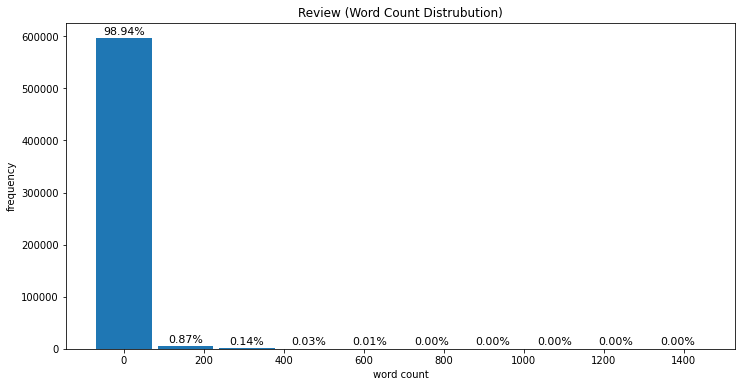

In [27]:
plt.subplots(figsize = (12, 6))
word_count = review_df['all_text_token'].str.len()
n, bins, patches = plt.hist(word_count, align = 'left', rwidth = 0.9, bins = 10)

for p in patches:
  plt.annotate("%2.2f%%" % ((p.get_height() / word_count.shape[0]) * 100), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha = 'center', va = 'center', fontsize = 11, xytext = (0, 7),
      textcoords = 'offset points')
  
plt.title('Review (Word Count Distrubution)')
plt.xlabel('word count')
plt.ylabel('frequency')
plt.show()

Overall, most of the reviews contain less than 100 words.

<h3>Plot the word count for each star rating class and see their distributions</h3>

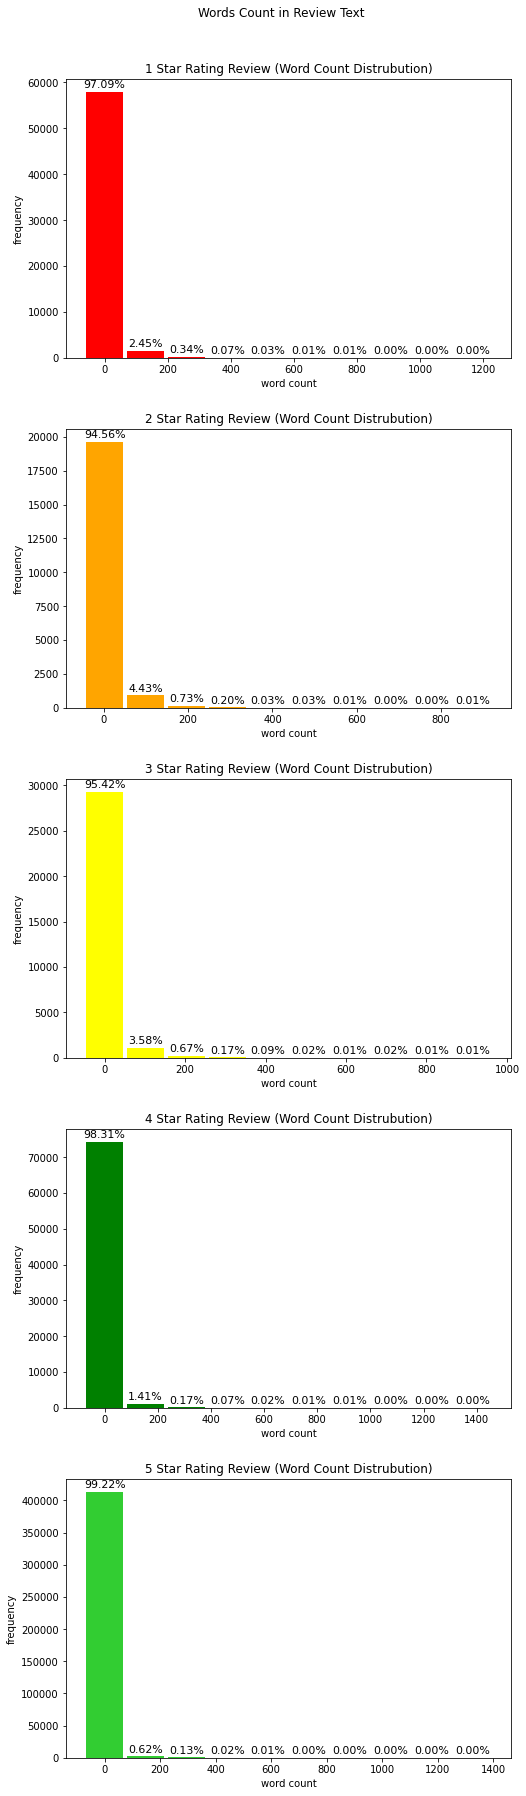

In [28]:
rows_n = 5
fig, axes = plt.subplots(nrows = rows_n, figsize = (8, 25))
plt.tight_layout(pad = 5)

color_dict = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'limegreen'}

for i in range(rows_n):
  word_count = review_df[review_df['overall'] == i + 1]['all_text_token'].str.len()
  axes[i].hist(word_count, align = 'left', rwidth = 0.9, bins = 10, color = color_dict[i])
  for p in axes[i].patches:
    axes[i].annotate("%2.2f%%" % ((p.get_height() / word_count.shape[0]) * 100), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center', va = 'center', fontsize = 11, xytext = (0, 7),
        textcoords = 'offset points')

for i in range(rows_n):
  axes[i].set_title('{} Star Rating Review (Word Count Distrubution)'.format(i + 1))
  axes[i].set_ylabel('frequency')
  axes[i].set_xlabel('word count')

fig.suptitle('Words Count in Review Text', y = 1.01)
plt.show()

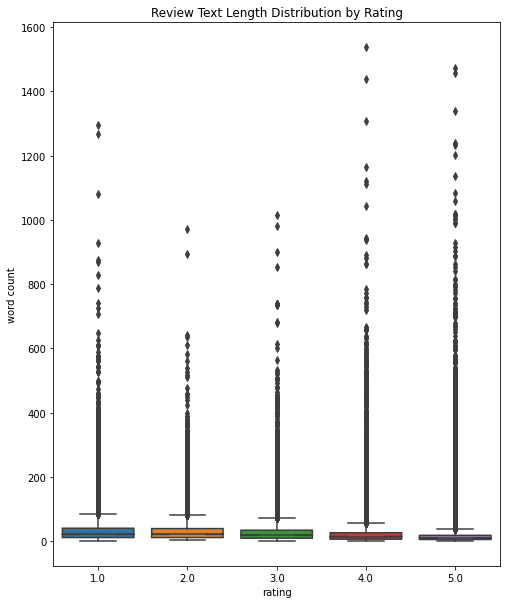

In [29]:
plt.figure(figsize=(8,10))
plt.title('Review Text Length Distribution by Rating')
ax = sns.boxplot(x="overall", y="word_count", data=review_df, notch=True)
ax.set(xlabel='rating', ylabel='word count')
plt.show()

The word counts distributions for each star rating review are similar, but if we compare the percentages, we could see that negative or low star rating reviews have more texts entered. 

The box plot shows that the 5 stars rating reviews have the lowest interquartile range (IQR) compared to the other 4 ratings, which implies that it has average the shortest review text.

<h3>Next, let's create a word cloud for each star rating and find out what's the most frequently used words.</h3>

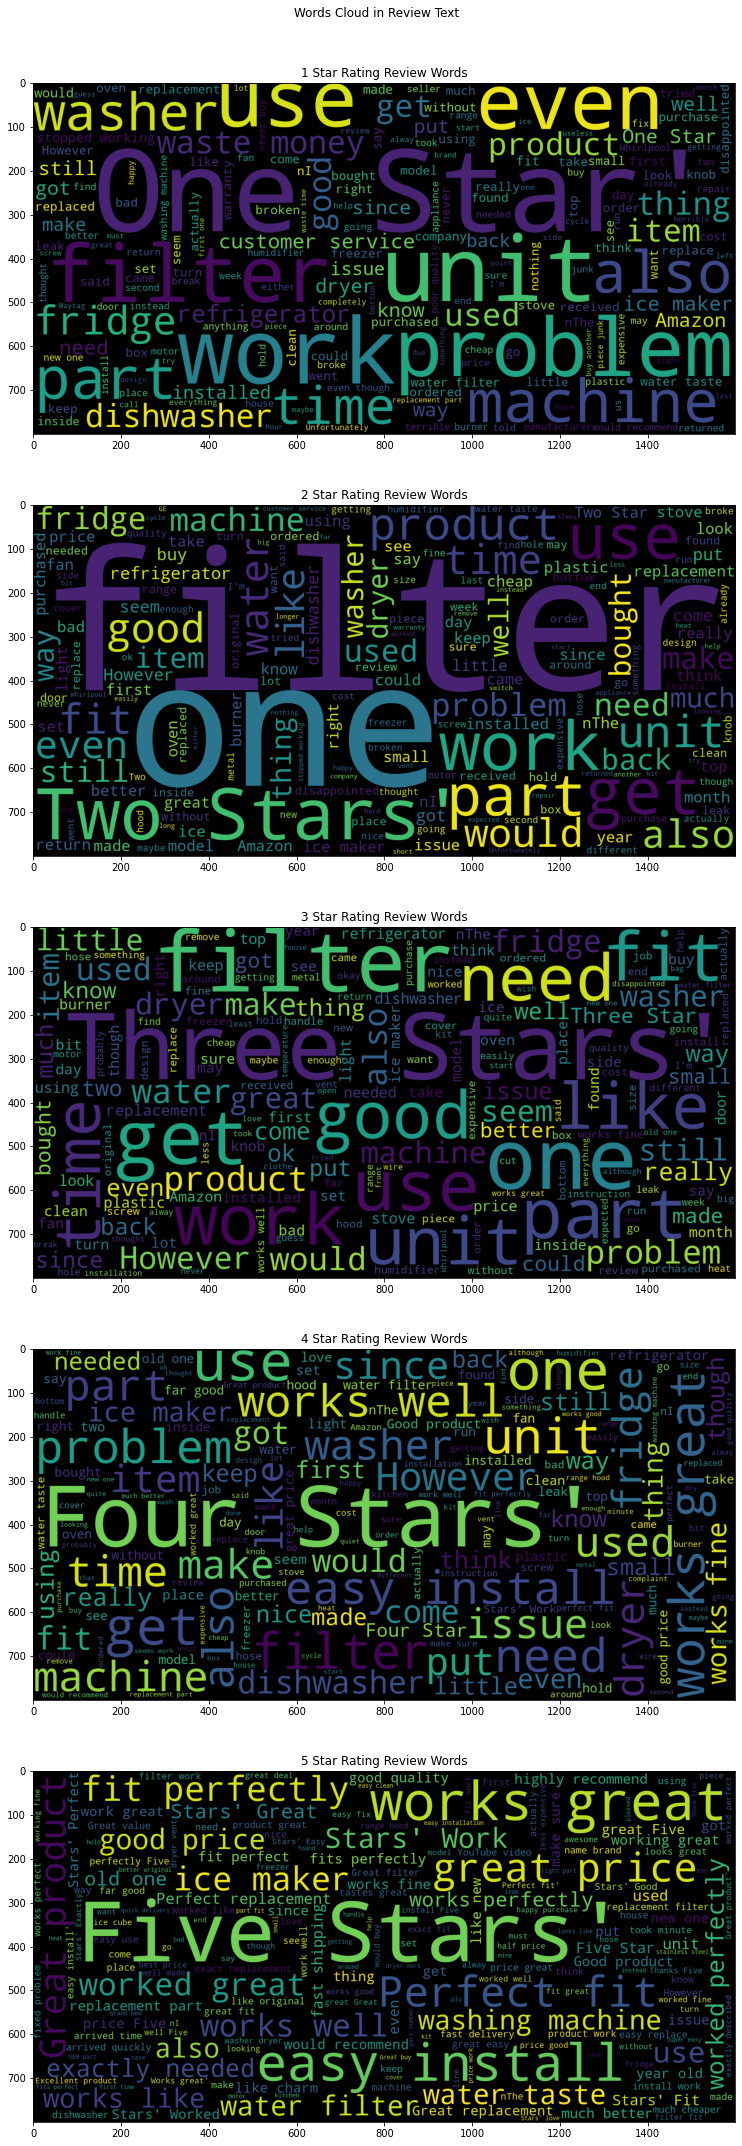

In [30]:
rows_n = 5
fig, axes = plt.subplots(nrows = rows_n, figsize = (12, 30))
plt.tight_layout(pad = 5)


for i in range(rows_n):
  wordcloud = WordCloud(width = 1600, height = 800, random_state = 1, stopwords = stop, background_color = 'black')
  wordcloud.generate(str(set(review_df[review_df['overall'] == i + 1]['all_text'])))
  axes[i].imshow(wordcloud)

for i in range(rows_n):
  axes[i].set_title('{} Star Rating Review Words'.format(i + 1))

fig.suptitle('Words Cloud in Review Text', y = 1.01)
plt.show()

The word cloud images show that 4 stars and 5 stars reviews have more positive words, and 1 star and 2 stars reviews tend to have more negative words.

## Product Data

### Data Cleaning

Load the original product dataset and clean it before use

In [31]:
product_df = getDF('/content/meta_Appliances.json.gz?raw=true')

In [32]:
product_df.head(5)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,"[Appliances, Refrigerators, Freezers & Ice Mak...","class=""a-keyvalue prodDetTable"" role=""present...",[],,Tupperware Freezer Square Round Container Set ...,[],,Tupperware,[Each 3-pc. set includes two 7/8-cup/200 mL an...,"[>#39,745 in Appliances (See top 100)]",[],{},Appliances,,"November 19, 2008",,7301113188,[],[]
1,"[Appliances, Refrigerators, Freezers & Ice Mak...","class=""a-keyvalue prodDetTable"" role=""present...",[2 X Tupperware Pure & Fresh Unique Covered Co...,,2 X Tupperware Pure &amp; Fresh Unique Covered...,[],,Tupperware,[2 X Tupperware Pure & Fresh Unique Covered Co...,"[>#6,118 in Appliances (See top 100)]",[B004RUGHJW],{},Appliances,,"June 5, 2016",$3.62,7861850250,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
2,"[Appliances, Parts &amp; Accessories]",,[],,The Cigar - Moments of Pleasure,[],,The Cigar Book,[],"[>#1,861,816 in Home &amp; Kitchen (See Top 10...","[B01HCAVSLK, 1632206579]",{},Amazon Home,,,$150.26,8792559360,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,"[Appliances, Parts & Accessories]","class=""a-keyvalue prodDetTable"" role=""present...","[Multi purpost descaler, especially suited to ...",,Caraselle 2X 50G Appliance Descalene,[],,Caraselle,[],"[>#1,654,505 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"December 17, 2014",.a-box-inner{background-color:#fff}#alohaBuyBo...,9792954481,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,"[Appliances, Parts & Accessories, Range Parts ...","class=""a-keyvalue prodDetTable"" role=""present...",[Full gauge and size beveled-edge; furnished w...,,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,[],,EATON Wiring,[Returns will not be honored on this closeout ...,"[>#3,066,990 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"January 16, 2007",$3.43,B00002N5EL,[],[]


In [33]:
product_df.shape

(30445, 19)

There are a total of 30,445 product records in this category, and the dataset has 19 different features.

<h3>check if any record has a null rating value.</h3>

In [34]:
product_df.isnull().sum()

category           0
tech1              0
description        0
fit                0
title              0
also_buy           0
tech2              0
brand              0
feature            0
rank               0
also_view          0
details            0
main_cat           0
similar_item       0
date               0
price              0
asin               0
imageURL           0
imageURLHighRes    0
dtype: int64

In [35]:
product_df.dtypes

category           object
tech1              object
description        object
fit                object
title              object
also_buy           object
tech2              object
brand              object
feature            object
rank               object
also_view          object
details            object
main_cat           object
similar_item       object
date               object
price              object
asin               object
imageURL           object
imageURLHighRes    object
dtype: object

All records in the dataset have a value for each column, so no need to replace the missing values.

<h3>Concatenate string list features into one string</h3>

The textual data in the product metadata is stored as a string list in the column, we would like to concatenate all the strings in the list into a single string for each column.

In [36]:
def concatenateString(text):
    text = ' '.join(text)
    return text

In [37]:
product_df['category'] = product_df['category'].apply(concatenateString)
product_df['description'] = product_df['description'].apply(concatenateString)
product_df['feature'] = product_df['feature'].apply(concatenateString)

<h3>Convert product release date to datetime data type and extract release year and month</h3> 

The product release time could be an important factor to understand customers' purchasing preferences, so year and month should be extracted from the product release datetime.

In [38]:
product_df['date'] = pd.to_datetime(product_df['date'].str.strip(), format='%B %d, %Y', errors='coerce')
product_df['dateYear'] = product_df['date'].dt.year
product_df['dateMonth'] = product_df['date'].dt.month
product_df = product_df.fillna('')

<h3>Extract product price</h3> 

The product price could be an important factor for a product recommendation, so the price should be extracted for future use. Replace any missing price with an empty value in the dataset.

In [39]:
def getPrice(text):
    text = re.findall('(\$\d+[,.]\d+(?:[.,]\d+)?)', text)
    text = concatenateString(text)
    text = text[1:]
    return text

In [40]:
product_df['price'] = product_df['price'].apply(getPrice)


<h3>Clean main category column</h3>

Removing special characters in the main category column

In [41]:
def replaceAmp(text):
    text = text.replace('&amp;', '&')
    return text


def replaceLink(text):
    if re.match(r'^<img', text):
      text = ''
    return text

In [42]:
product_df['brand'] = product_df['brand'].replace('', 'No brand')
product_df['main_cat'] = product_df['main_cat'].apply(replaceAmp)
product_df['main_cat'] = product_df['main_cat'].apply(replaceLink)

<h3>Drop the unnecessary columns from the original dataset.</h3>

In [43]:
product_df = product_df[['category', 'description', 'title', 'brand', 'feature', 'main_cat', 'date', 'price', 'asin', 'imageURLHighRes', 'dateYear', 'dateMonth']]

In [44]:
product_df.head(5)

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth
0,"Appliances Refrigerators, Freezers & Ice Makers",,Tupperware Freezer Square Round Container Set ...,Tupperware,Each 3-pc. set includes two 7/8-cup/200 mL and...,Appliances,2008-11-19,,7301113188,[],2008.0,11.0
1,"Appliances Refrigerators, Freezers & Ice Makers",2 X Tupperware Pure & Fresh Unique Covered Coo...,2 X Tupperware Pure &amp; Fresh Unique Covered...,Tupperware,2 X Tupperware Pure & Fresh Unique Covered Coo...,Appliances,2016-06-05,3.62,7861850250,[https://images-na.ssl-images-amazon.com/image...,2016.0,6.0
2,Appliances Parts &amp; Accessories,,The Cigar - Moments of Pleasure,The Cigar Book,,Amazon Home,NaT,150.26,8792559360,[https://images-na.ssl-images-amazon.com/image...,,
3,Appliances Parts & Accessories,"Multi purpost descaler, especially suited to w...",Caraselle 2X 50G Appliance Descalene,Caraselle,,Tools & Home Improvement,2014-12-17,,9792954481,[https://images-na.ssl-images-amazon.com/image...,2014.0,12.0
4,Appliances Parts & Accessories Range Parts & A...,Full gauge and size beveled-edge; furnished wi...,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,EATON Wiring,Returns will not be honored on this closeout i...,Tools & Home Improvement,2007-01-16,3.43,B00002N5EL,[],2007.0,1.0


Now, all the null values are handled and only the useful columns are kept in the dataset, so the cleaned product dataset is ready to be used for exploratory data analysis.

### Data Analysis

<h3>Display the price list in the dataset</h3>

In [45]:
product_df['price'].value_counts()

          10401
24.99       221
11.99       214
14.99       156
12.99       117
          ...  
42.75         1
52.67         1
85.77         1
6.86          1
250.79        1
Name: price, Length: 7862, dtype: int64

There are a total of 10,401 products that don't have a price, so this feature might not be very helpful for building our recommender systems.

<h3>Display the main category in the dataset and its distribution</h3>

In [46]:
product_df['main_cat'].value_counts()

Tools & Home Improvement     19561
Appliances                    6518
Amazon Home                   2685
Industrial & Scientific       1100
Automotive                     190
                                97
All Electronics                 44
Health & Personal Care          37
All Beauty                      29
Sports & Outdoors               28
Baby                            28
Cell Phones & Accessories       20
Arts, Crafts & Sewing           18
Office Products                 17
Musical Instruments             14
Home Audio & Theater            14
Computers                       14
Grocery                         10
Camera & Photo                   8
Pet Supplies                     6
Toys & Games                     6
Books                            1
Name: main_cat, dtype: int64

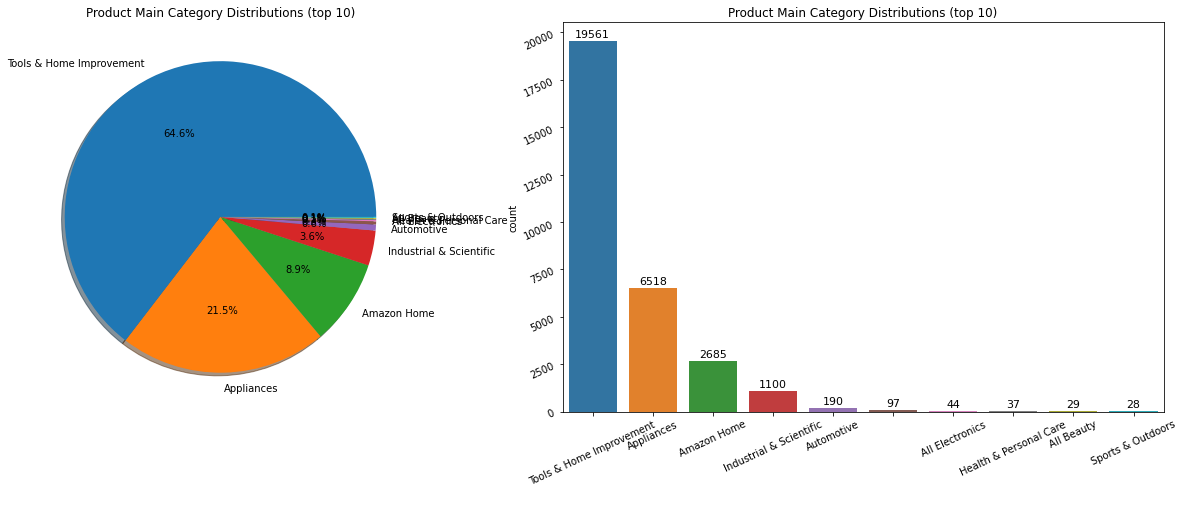

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
plt.tight_layout()

product_df['main_cat'].value_counts().nlargest(10).plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)
ax=sns.countplot(x="main_cat", data=product_df, ax=axes[1], order=pd.value_counts(product_df['main_cat']).iloc[:10].index)

for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Product Main Category Distributions (top 10)')
axes[0].set_ylabel(' ')

axes[1].set_title('Product Main Category Distributions (top 10)')
axes[1].set_xlabel(' ')
axes[1].tick_params(labelrotation=25)
plt.show()

The results show that the majority of the products (64.6%) are in the Tools & Home Improvement category, and the Appliances category also holds 21.5% in the dataset.

<h3>Display the brand in the dataset and its distribution</h3>

In [48]:
product_df['brand'].value_counts()

Whirlpool                  5854
GE                         3290
Frigidaire                 2660
LG                         1262
Samsung                     978
                           ... 
Command Performance           1
Fire Magic                    1
Vanish                        1
SUB-ZERO                      1
Champion - Moyer Diebel       1
Name: brand, Length: 2762, dtype: int64

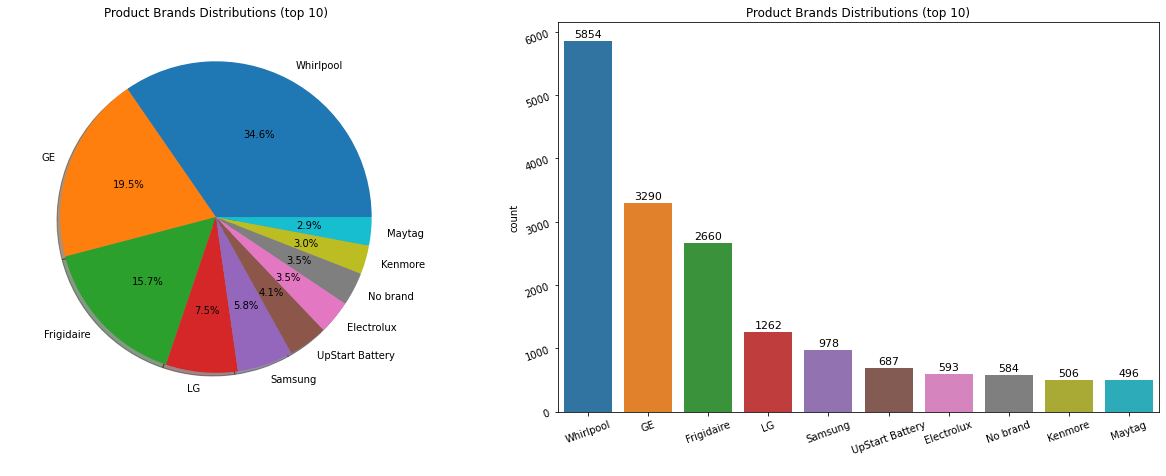

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
plt.tight_layout()

product_df['brand'].value_counts().nlargest(10).plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)
ax=sns.countplot(x="brand", data=product_df, ax=axes[1], order=pd.value_counts(product_df['brand']).iloc[:10].index)

for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Product Brands Distributions (top 10)')
axes[0].set_ylabel(' ')

axes[1].set_title('Product Brands Distributions (top 10)')
axes[1].set_xlabel(' ')
axes[1].tick_params(labelrotation=20)
plt.show()

There are a total of 2,762 brands in the Appliances category, and Whirlpool has the rank 1 position of amount of products.

<h3>List the ranking of most reviewed products and their average ratings.</h3>

In [50]:
product_grouped = review_df.groupby('asin').size().reset_index(name='counts')
product_grouped_rating = review_df.groupby('asin')['overall'].sum().reset_index(name='overall_sum')
product_grouped['rating_mean'] = product_grouped_rating['overall_sum'] / product_grouped['counts']
product_grouped = product_grouped.sort_values('counts', ascending=False)
product_grouped

,asin,counts,rating_mean
421,B000AST3AK,6510,4.422427
5891,B004UB1O9Q,5702,4.341810
1634,B0014CN8Y8,4048,4.676383
17054,B00KJ07SEM,3200,4.409063
5289,B0045LLC7K,2936,4.403270
...,...,...,...
15012,B00GMJ0QCU,1,5.000000
15013,B00GMJ1IDQ,1,5.000000
15014,B00GMJ1XYU,1,5.000000
15018,B00GMJ5SGY,1,4.000000


Among 30,445 Appliances products, there are only 30,252 products were reviewed.

Let's find out the detail of the most and second most reviewed product in the dataset.

Most reviewed product: General Electric MWF Refrigerator Water Filter


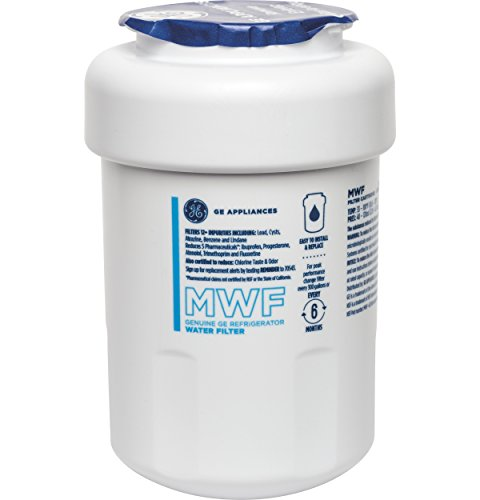

In [51]:
print('Most reviewed product: {}'.format(product_df[product_df['asin'] == product_grouped.iloc[0]['asin']]['title'].item()))
Image(product_df[product_df['asin'] == product_grouped.iloc[0]['asin']]['imageURLHighRes'].tolist()[0][0])

Second most reviewed product: Samsung Genuine DA29-00020B Refrigerator Water Filter, 3 Pack


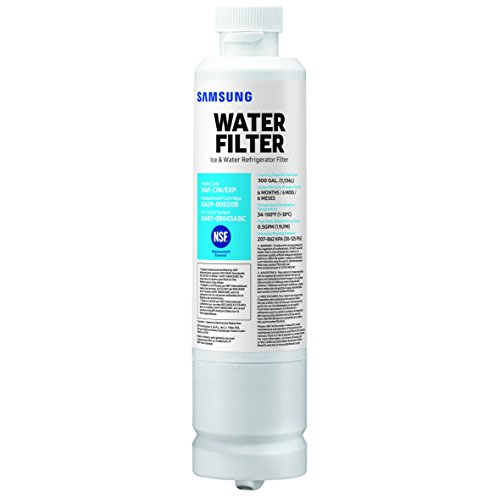

In [52]:
print('Second most reviewed product: {}'.format(product_df[product_df['asin'] == product_grouped.iloc[1]['asin']]['title'].item()))
Image(product_df[product_df['asin'] == product_grouped.iloc[1]['asin']]['imageURLHighRes'].tolist()[0][0])

The top 2 most reviewed products are both Refrigerator Water Filter.

### Product text analysis


Remove stop word from the product text and apply text tokenization

Append all textual data columns into a single column then tokenize the text data altogether. Besides, count the word numbers for each product record.

In [53]:
product_df['all_text'] = product_df['category'] + ' ' + product_df['description'] + ' ' + product_df['title'] + ' ' + product_df['feature']
product_df['all_text_token'] = product_df['all_text'].apply(tokenizer)
product_df['word_count'] = product_df['all_text_token'].str.len()

In [54]:
product_df.head(5)

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,all_text,all_text_token,word_count
0,"Appliances Refrigerators, Freezers & Ice Makers",,Tupperware Freezer Square Round Container Set ...,Tupperware,Each 3-pc. set includes two 7/8-cup/200 mL and...,Appliances,2008-11-19,,7301113188,[],2008.0,11.0,"Appliances Refrigerators, Freezers & Ice Maker...","[appliances, refrigerators, freezers, ice, mak...",51
1,"Appliances Refrigerators, Freezers & Ice Makers",2 X Tupperware Pure & Fresh Unique Covered Coo...,2 X Tupperware Pure &amp; Fresh Unique Covered...,Tupperware,2 X Tupperware Pure & Fresh Unique Covered Coo...,Appliances,2016-06-05,3.62,7861850250,[https://images-na.ssl-images-amazon.com/image...,2016.0,6.0,"Appliances Refrigerators, Freezers & Ice Maker...","[appliances, refrigerators, freezers, ice, mak...",117
2,Appliances Parts &amp; Accessories,,The Cigar - Moments of Pleasure,The Cigar Book,,Amazon Home,NaT,150.26,8792559360,[https://images-na.ssl-images-amazon.com/image...,,,Appliances Parts &amp; Accessories The Cigar ...,"[appliances, parts, amp, accessories, cigar, m...",7
3,Appliances Parts & Accessories,"Multi purpost descaler, especially suited to w...",Caraselle 2X 50G Appliance Descalene,Caraselle,,Tools & Home Improvement,2014-12-17,,9792954481,[https://images-na.ssl-images-amazon.com/image...,2014.0,12.0,Appliances Parts & Accessories Multi purpost d...,"[appliances, parts, accessories, multi, purpos...",29
4,Appliances Parts & Accessories Range Parts & A...,Full gauge and size beveled-edge; furnished wi...,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,EATON Wiring,Returns will not be honored on this closeout i...,Tools & Home Improvement,2007-01-16,3.43,B00002N5EL,[],2007.0,1.0,Appliances Parts & Accessories Range Parts & A...,"[appliances, parts, accessories, range, parts,...",69


In [55]:
product_df['word_count'].value_counts()

44      739
33      599
34      547
32      544
35      537
       ... 
1805      1
1328      1
539       1
690       1
487       1
Name: word_count, Length: 541, dtype: int64

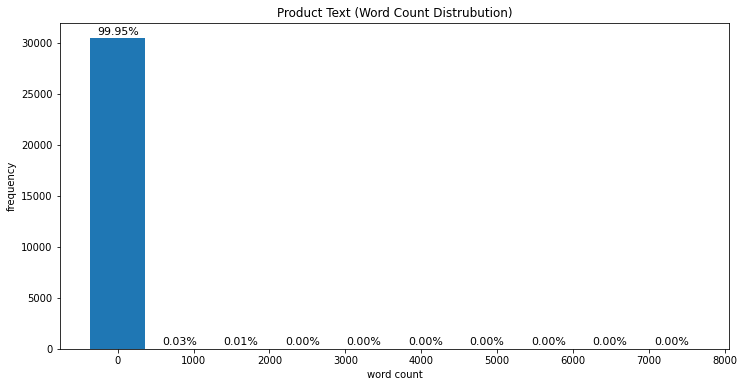

In [56]:
plt.subplots(figsize = (12, 6))
word_count = product_df['all_text_token'].str.len()
n, bins, patches = plt.hist(word_count, align = 'left', rwidth = 0.9, bins = 10)

for p in patches:
  plt.annotate("%2.2f%%" % ((p.get_height() / word_count.shape[0]) * 100), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha = 'center', va = 'center', fontsize = 11, xytext = (0, 7),
      textcoords = 'offset points')
  
plt.title('Product Text (Word Count Distrubution)')
plt.xlabel('word count')
plt.ylabel('frequency')
plt.show()

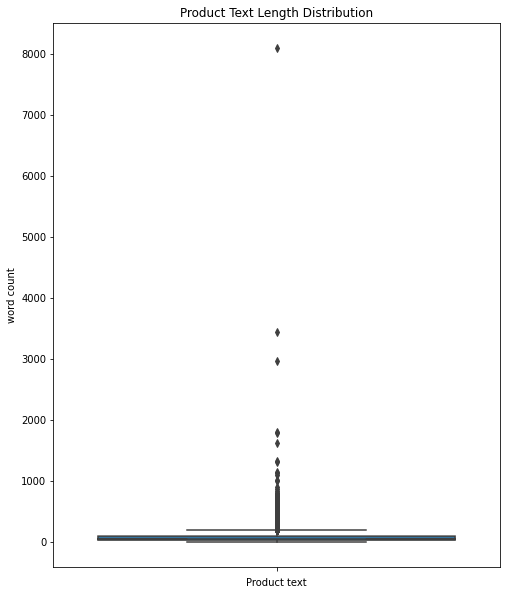

In [57]:
plt.figure(figsize=(8,10))
plt.title('Product Text Length Distribution')
ax = sns.boxplot( y="word_count", data=product_df, notch=True)
ax.set(xlabel='Product text', ylabel='word count')
plt.show()

The product text distribution histogram and box plot show that majority of the product text is less than 1000 words. There are only a few outliers that are greater than 2000 words, so for future NLP model development, in order to reduce the padding size, we can choose a smaller number instead.

<h3>Next, let's create a word cloud for the entire product dataset and find out what's the most frequently used words for the Appliances products.</h3>

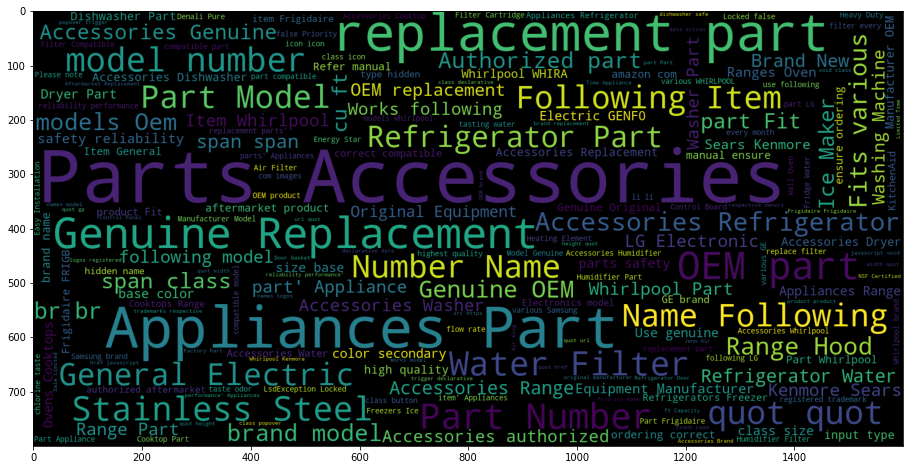

In [58]:
plt.figure(figsize=(16,8))
wordcloud = WordCloud(width = 1600, height = 800, random_state = 1, stopwords = stop, background_color = 'black')
wordcloud.generate(str(set(product_df['all_text'])))
plt.imshow(wordcloud)

fig.suptitle('Words Cloud in Product Text', y = 1.01)
plt.show()

The word cloud shows that the most frequently used words for Appliances products are related to replacement, part, and model.

###Merge review and product data to find more insights

In [59]:
merged_df = review_df.merge(product_df, on='asin', how='left')

<h3>Display the most reviewed brand in the dataset and its distribution</h3>

In [60]:
merged_grouped = merged_df.groupby('brand').size().reset_index(name='review_counts')
merged_grouped_rating = merged_df.groupby('brand')['overall'].sum().reset_index(name='overall_sum')
merged_grouped['rating_mean'] = merged_grouped_rating['overall_sum'] / merged_grouped['review_counts']
merged_grouped = merged_grouped.sort_values('review_counts', ascending=False)
merged_grouped

,brand,review_counts,rating_mean
2591,Whirlpool,108295,4.477280
991,GE,40213,4.357049
967,Frigidaire,33581,4.367738
1491,LG,22630,4.382501
2159,Samsung,19109,4.285258
...,...,...,...
1480,Kyz Kuv,1,1.000000
1481,L M Electrical,1,5.000000
1482,L2go,1,1.000000
1496,LIFE WITHOUT PLASTIC,1,5.000000


Among 2.762 Appliances brands, Whirlpool products have the most reviews number with a 4.48 average rating score.

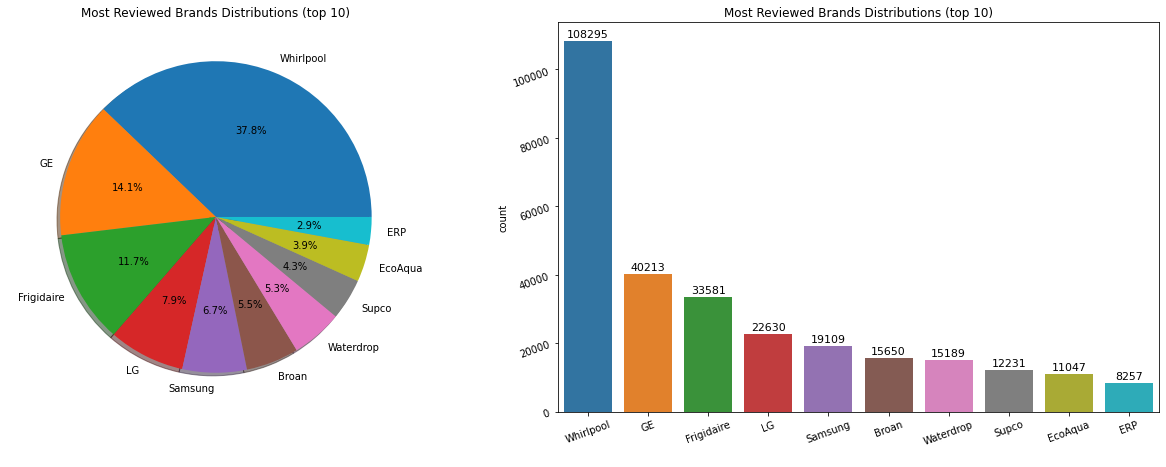

In [61]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
plt.tight_layout()

merged_df['brand'].value_counts().nlargest(10).plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)
ax=sns.countplot(x="brand", data=merged_df, ax=axes[1], order=pd.value_counts(merged_df['brand']).iloc[:10].index)

for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Most Reviewed Brands Distributions (top 10)')
axes[0].set_ylabel(' ')

axes[1].set_title('Most Reviewed Brands Distributions (top 10)')
axes[1].set_xlabel(' ')
axes[1].tick_params(labelrotation=20)
plt.show()

The result is very similar compared with the brand distribution in the product dataset, and Whirlpool products have the rank 1 position of amount of reviews.

However, there are some other brands in the list that are not in the list of top 10 product numbers, which means offering more products doesn't imply more purchasing and revenue.

<h3>Display the top 10 average rating brand (reviews > 5000) in the dataset and its distribution </h3>

There are many brand only have a few reviews, and their average rating will definitely be higher than other brands with more reviews, so we only consider the brands with at least 5,000 reviews for this analysis.

In [62]:
merged_rating_grouped = merged_grouped[merged_grouped['review_counts'] > 5000].sort_values('rating_mean', ascending=False)
merged_rating_grouped.head(10)

,brand,review_counts,rating_mean
1536,LintEater,6088,4.617280
2570,Waterdrop,15189,4.525183
2294,Supco,12231,4.494808
2591,Whirlpool,108295,4.477280
1419,Kenmore,5490,4.389253
1491,LG,22630,4.382501
769,ERP,8257,4.378225
793,EcoAqua,11047,4.374038
967,Frigidaire,33581,4.367738
991,GE,40213,4.357049


The result show that brand LintEater has the highest average rating 4.62 with over 6,000 reviews. 

Whereas Whirlpool has the rank 4 in this list, it also has the most review number and most products offered in the Appliance category. It means Whirlpool is doing great in offering both overall product quality and quantity.

## Save our cleaned datasets for future model developments

In [63]:
compression_opts = dict(method='zip',archive_name='cleaned_amazon_review.csv')  
review_df.to_csv('cleaned_amazon_review.zip', index=False, header = True, compression=compression_opts)  

In [64]:
compression_opts = dict(method='zip',archive_name='cleaned_amazon_product.csv')  
product_df.to_csv('cleaned_amazon_product.zip', index=False, header = True, compression=compression_opts)  